# **Clasificador Support Vectors Machine**
Un SVM es un clasificador binario que utiliza un hiperplano para dividir el espacio en 2, de modo que todas las muestras que se encuentren a un lado del hiperplano corresponden a una clase, y todas las muestras del otro lado del hiperplano corresponden a la otra clase.

El hiperplano separador se construye a partir de un problema de optimización, que encuentra la mayor distancia entre el hiperplano y las muestras más cercanas de cada clase. A estas muestras que definen al hiperplano se les llama *vectores de soporte*.

El conjunto de datos utilizado para este notebook corresponde al dataset [HTRU2](https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip), el cuál contiene información para la clasificación de pulsares.

In [1]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import svm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


Para trabajar con los datos que contiene el dataset se ha creado un DataFrame con la información del archivo csv. La lista *headers* contiene los nombres de cada una de las columnas.

In [2]:
# El archivo "HTRU_2.csv" debe encontrarse en el mismo directorio que este notebook. De no ser así, proporcione
# la ubicación del archivo en la variable path.
path = "HTRU/HTRU_2.csv"
headers = ['mean_prof','std_prof','exkurt_prof','skew_prof','mean_curve','std_curve','exkurt_curve','skew_curve','class']
data = pd.read_csv(path, names=headers)

Visualización de las primeras 5 filas del DataFrame.

In [3]:
data.head()


,mean_prof,std_prof,exkurt_prof,skew_prof,mean_curve,std_curve,exkurt_curve,skew_curve,class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


Para asegurar la reproductibilidad del código se ha utilizado una semilla.

In [4]:
seed = 1


Un SVM no tiene buen rendimiento cuando el problema está muy desbalanceado. Por este motivo, en esta oportunidad se ha decidido la opción del *undersampling*: vale decir, se han descartado muestras de la clase mayoritaria para que el conjunto de datos contenga la misma cantidad de ejemplos para cada clase.

In [5]:
# divide_class: DataFrame --> DataFrame, DataFrame
# Esta función recibe un dataset en formato DataFrame, y devuelve un
# DataFrame con la clase positiva y otro con la clase negativa.
def class_split(dataset):
    # Se asume que las clases se encuentran en la última columna.
    labels_col = dataset.columns[-1]
    negative = dataset.loc[dataset[labels_col] == 0]
    positive = dataset.loc[dataset[labels_col] == 1]

    return negative, positive


In [6]:
# undersampling: DataFrame, int --> DataFrame
# Esta función recibe un dataset en formato DataFrame y una semilla,
# y devuelve un DataFrame con igual proporción de clases.
def undersampling(dataset, seed=None):
    negative_samples, positive_samples = class_split(dataset)

    num_neg_samples = negative_samples.shape[0]
    num_pos_samples = positive_samples.shape[0]

    if num_neg_samples > num_pos_samples:
        undersampled = negative_samples.sample(n=num_pos_samples, random_state=seed)
        return pd.concat([undersampled, positive_samples], ignore_index=True)

    elif num_neg_samples < num_pos_samples:
        undersampled = positive_samples.sample(n=num_neg_samples, random_state=seed)
        return pd.concat([negative_samples, undersampled], ignore_index=True)

    else:
        return pd.concat([negative_samples, positive_samples], ignore_index=True)
        

Como se puede ver, ahora ambas clases cuentan con la misma cantidad de muestras.

In [7]:
no_pulsar, pulsar = class_split(undersampling(data, seed=seed))
print(no_pulsar.shape, pulsar.shape)

(1639, 9) (1639, 9)


Para trabajar con el clasificador SVM se decidió particionar el conjunto de datos en 3 subconjuntos: training, validation y test. La proporción de esta partición es de 60/20/20.

In [8]:
# tvt_split: DataFrame, int --> DataFrame, DataFrame, DataFrame, Series, Series, Series
# Esta función recibe un dataset en formato DataFrame y una semilla, y devuelve
# un DataFrame y Series para los conjuntos de train, valdiation y test.
def tvt_split(dataset, seed=None):
    labels = dataset.iloc[:,-1]
    samples = dataset.iloc[:,:-1]

    # Primero se obtienen los datos de test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        samples, labels, test_size=0.2, random_state=seed, stratify=labels)
    
    # Luego se separan los datos de train y val. Notar que estos datos corresponde
    # al 0.8 del total, por lo tanto 0.75*0.8 = 0.6 es la fracción de muestras
    # para el conjunto de train.
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, train_size=0.75, random_state=seed, stratify=y_train_val)

    return X_train, X_val, X_test, y_train, y_val, y_test

Para verificar que la distribución de los datos no se ha alterado significativamente se muestran a continuación los histogramas de todas las características para cada conjunto.

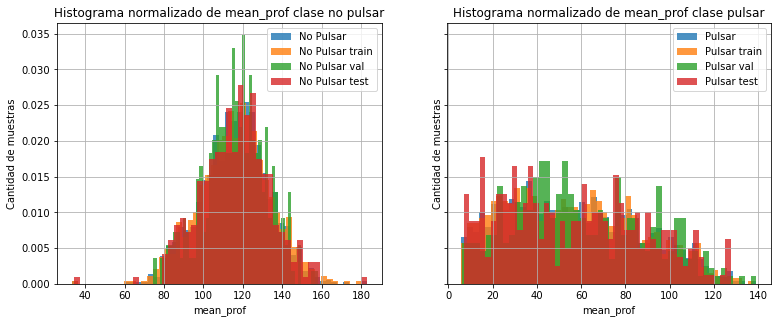

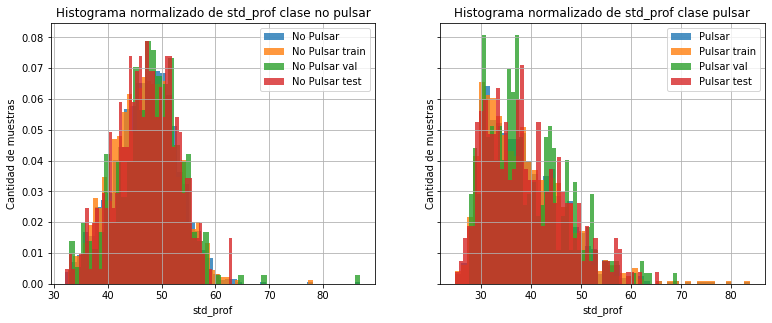

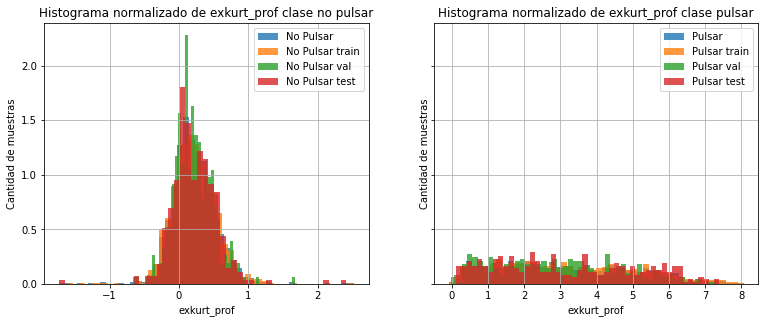

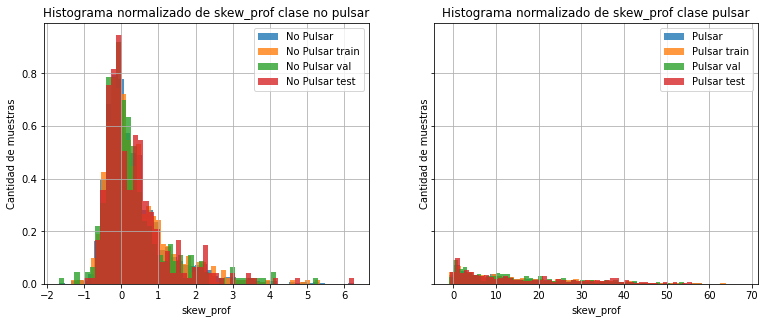

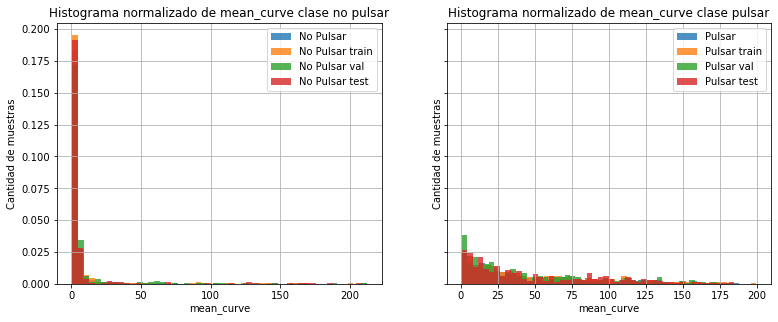

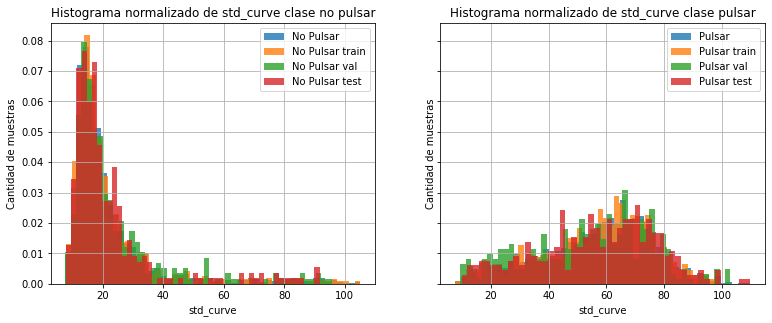

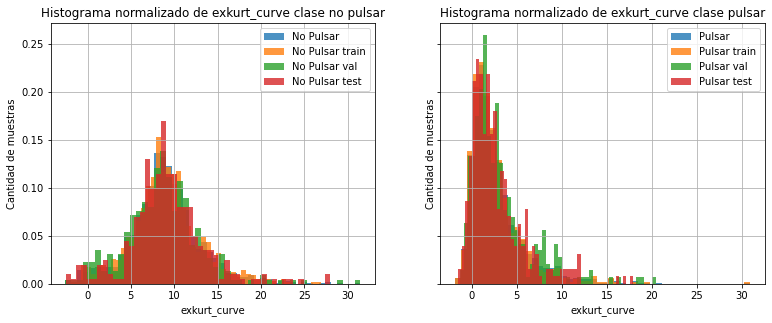

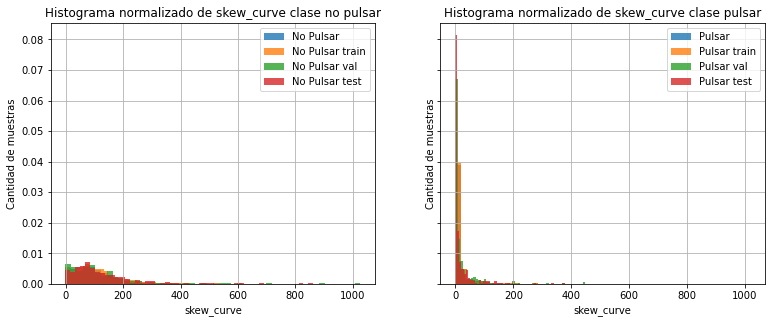

In [9]:
for i in range(len(headers)-1):
    X_train, X_val, X_test, _, _, _ = tvt_split(no_pulsar, seed)

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12.8, 4.8))
    ax1.hist(no_pulsar[headers[i]], 50, alpha=0.8, density=True, label='No Pulsar')
    ax1.hist(X_train[headers[i]], 50, alpha=0.8, density=True, label='No Pulsar train')
    ax1.hist(X_val[headers[i]], 50, alpha=0.8, density=True, label='No Pulsar val')
    ax1.hist(X_test[headers[i]], 50, alpha=0.8, density=True, label='No Pulsar test')

    ax1.set_xlabel(headers[i])
    ax1.set_ylabel('Cantidad de muestras')
    ax1.set_title(f'Histograma normalizado de {headers[i]} clase no pulsar')
    ax1.legend()
    ax1.grid(True)

    X_train, X_val, X_test, _, _, _ = tvt_split(pulsar, seed)

    ax2.hist(pulsar[headers[i]], 50, alpha=0.8, density=True, label='Pulsar')
    ax2.hist(X_train[headers[i]], 50, alpha=0.8, density=True, label='Pulsar train')
    ax2.hist(X_val[headers[i]], 50, alpha=0.8, density=True, label='Pulsar val')
    ax2.hist(X_test[headers[i]], 50, alpha=0.8, density=True, label='Pulsar test')

    ax2.set_xlabel(headers[i])
    ax2.set_ylabel('Cantidad de muestras')
    ax2.set_title(f'Histograma normalizado de {headers[i]} clase pulsar')
    ax2.legend()
    ax2.grid(True)
    plt.show()

Así como datasets muy desbalanceados afectan negativamente al clasificador, el mismo inconveniente se puede encontrar cuando el orden de magnitud de las características difieren mucho entre sí. Debido a lo anterior, resulta útil normalizar los datos para que no exista un sesgo de algún subconjunto de características por sobre el resto.

In [10]:
# standardize_data: DataFrame, DataFrame, DataFrame --> array, array, array
# Esta función recibe los conjuntos de entrenamiento, validación y prueba, y
# devuelve estos conjuntos normalizados por el conjunto de entrenamiento.
def standardize_data(train, validation, test):
    scaler =  StandardScaler().fit(train)
    scaled_train = scaler.transform(train)
    scaled_validation = scaler.transform(validation)
    scaled_test = scaler.transform(test)

    return scaled_train, scaled_validation, scaled_test

Otro punto a considerar corresponde a la elección de hiperparámetros. En un clasificador SVM, los hiperparámetros dependerán del kernel seleccionado, de modo que el parámetro *degree* será relevante sólo para un kernel polinomial por dar un ejemplo.

In [11]:
# best_SVC: array, str, dict, int, num, num --> clasificador
# Esta función toma un conjunto de entrenamiento, y lo utiliza
# para entrenar los clasificadores con los hiperparámetros entregados.
# Retorna el mejor clasificador obtenido.
def best_SVC(train, labels, kernel, parameters, degree=2, coef0=1, gamma=1):
  if kernel == 'poly':
    SVC = svm.SVC(kernel=kernel, degree=degree, coef0=coef0, gamma=gamma)
  else:
    SVC = svm.SVC(kernel=kernel)
  
  classifier = GridSearchCV(SVC, parameters)
  classifier.fit(train, labels)

  return classifier

A modo de visualizar el desempeño del clasificador se ha implementado una matriz de confusión.

In [12]:
def confusion_mtx(SVC, samples, labels):
  predictions = SVC.predict(samples)
  return confusion_matrix(labels, predictions)
  

Dado lo anterior, debiese ser posible encontrar un buen clasificador SVM y visualizar sus resultados con una matriz de confusión.

Primero se obtienen los datos necesarios para entrenamiento, validación y test.

In [13]:
undersampled = undersampling(data, seed=seed)
X_train, X_val, X_test, y_train, y_val, y_test = tvt_split(undersampled, seed=seed)
X_train, X_val, X_test = standardize_data(X_train, X_val, X_test)

A continuación se definen los hiperparámetros. Por el momento sólo se ha elegido un kernel lineal y un conjunto de valores de $C$ que serán analizados en una grilla.

In [14]:
parameters = {'C': [0.1,1,10,100,1000]}
linear_kernel = best_SVC(X_train, y_train, 'linear', parameters)

Con el clasificador ya encontrado y entrenado, sólo basta mostrar sus resultados por medio de la matriz de confusión.

In [15]:
confusion_mtx(linear_kernel, X_val, y_val)


array([[323,   5],
       [ 26, 302]], dtype=int64)

Cómo se puede ver en la matriz, la cantidad de errores de ambos tipos cometidos por el clasificador es baja en comparación a la cantidad de muestras en la validación.

Con el objetivo de obtener métricas para comparar clasificadores, también se ha implementado una función que permite obtener la curva ROC y el área bajo la curva; y también la curva PR y el average precision,

In [16]:
def ROC(SVC, samples, labels):
    predictions = SVC.decision_function(samples)
    FPR, TPR, _ = roc_curve(labels, predictions)
    return FPR, TPR, roc_auc_score(labels, predictions)

In [17]:
def plot_ROC(*ROC_curves, labels=None):
    ax = plt.subplot()
    for curve in ROC_curves:
        ax.plot(curve[0], curve[1])

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Curva ROC')
    ax.grid()

    if labels is not None:
        ax.legend(labels)
        
    fig.show()
    

In [18]:
def PR(SVC, samples, labels):
    predictions = SVC.decision_function(samples)
    precision, recall, _ = precision_recall_curve(labels, predictions)
    return precision, recall, average_precision_score(labels, predictions)

In [19]:
def plot_PR(*PR_curves, labels=None):
    ax = plt.subplot()
    for curve in PR_curves:
        ax.plot(curve[0], curve[1])

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Curva Precision Recall')
    ax.grid()

    if labels is not None:
        ax.legend(labels)
        
    fig.show()

Se calculan los valores de FPR y TPR para graficar la curva ROC, además de guardar el valor del área bajo la curva ROC.

C:\Users\Esteban\AppData\Local\Temp/ipykernel_8980/1217462674.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


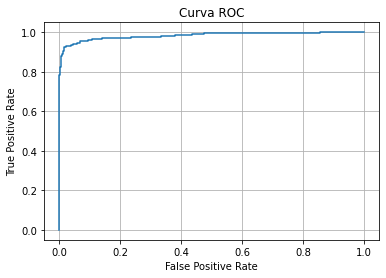

In [20]:
FPR, TPR, ROC_AUC = ROC(linear_kernel, X_val, y_val)
plot_ROC((FPR, TPR))


Análogamente, se calculan los valores de recall y precision para graficar la curva PR, además de almacenar la métrica de average precision.

C:\Users\Esteban\AppData\Local\Temp/ipykernel_8980/3616447253.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


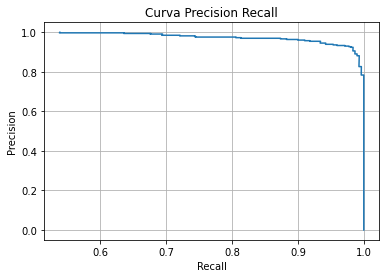

In [21]:
recall, precision, AP = PR(linear_kernel, X_val, y_val)
plot_PR((recall, precision))

Aunque el kernel lineal logró entregar buenos resultados, resulta interesante conocer el desempeño de un clasificador SVM utilizando otros kernels. Para ello, se ha entrenado un clasificador con kernel polinomial de grado 2, otro con kernel polinomial grado 3, y finalmente un clasificador con kernel RBF.

In [22]:
# Parámetros a buscar con gread search.
poly2_params = {'C': [0.01,0.1,1,10,100]}
poly3_params = {'C': [0.01,0.1,1,10,100]}
rbf_params = {'C': [0.1,1,10,100,1000], 'gamma': [0.001,0.01,0.1,1]}

# Búsqueda de mejores parámetros y entrenamiento.
poly2_kernel = best_SVC(X_train, y_train, 'poly', poly2_params)
poly3_kernel = best_SVC(X_train, y_train, 'poly', poly3_params, degree=3)
rbf_kernel = best_SVC(X_train, y_train, 'rbf', rbf_params)

classifiers = [linear_kernel, poly2_kernel, poly3_kernel, rbf_kernel]

Con todos los clasificadores ya entrenados, se procede a realizar predicciones sobre el conjunto de validación para encontrar el mejor de todos.

In [23]:
# Cálculo de las matrices de confusión.
linear_cm = confusion_mtx(linear_kernel, X_val, y_val)
poly2_cm = confusion_mtx(poly2_kernel, X_val, y_val)
poly3_cm = confusion_mtx(poly3_kernel, X_val, y_val)
rbf_cm = confusion_mtx(rbf_kernel, X_val, y_val)

C:\Users\Esteban\AppData\Local\Temp/ipykernel_8980/1217462674.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Esteban\AppData\Local\Temp/ipykernel_8980/3616447253.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


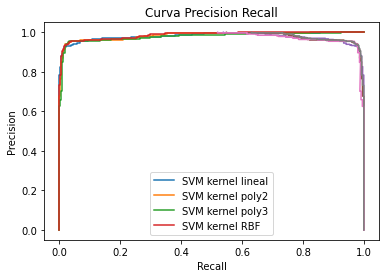

In [24]:
ROC_curves = []
PR_curves = []

for classifier in classifiers:
    fpr, tpr, auc = ROC(classifier, X_val, y_val)
    rec, prec, ap = PR(classifier, X_val, y_val)

    ROC_curves.append((fpr, tpr, auc))
    PR_curves.append((rec, prec, ap))

labels = ["SVM kernel lineal", "SVM kernel poly2", "SVM kernel poly3", "SVM kernel RBF"]
plot_ROC(*ROC_curves, labels=labels)
plot_PR(*PR_curves, labels=labels)

Para facilitar la visualización de cada métrica se ha generado un DataFrame con la información pertinente.

In [25]:
clf_scores = {'Confusion Matrix': [linear_cm, poly2_cm, poly3_cm, rbf_cm],
              'ROC AUC': [ROC_curves[0][2], ROC_curves[1][2], ROC_curves[2][2], ROC_curves[3][2]],
              'Average Precision': [PR_curves[0][2], PR_curves[1][2], PR_curves[2][2], PR_curves[3][2]]}
scores = pd.DataFrame(data=clf_scores, index=['Linear Kernel', 'Poly2 Kernel', 'Poly3 Kernel', 'RBF Kernel'])
scores.sort_values(by='Average Precision', ascending=False)


,Confusion Matrix,ROC AUC,Average Precision
RBF Kernel,"[[320, 8], [21, 307]]",0.986336,0.988700
Poly2 Kernel,"[[322, 6], [20, 308]]",0.983827,0.987060
Linear Kernel,"[[323, 5], [26, 302]]",0.982795,0.986913
Poly3 Kernel,"[[320, 8], [19, 309]]",0.978528,0.983444


Finalmente, el mejor clasificador encontrado por medio del conjunto de validación es utilizado en el conjunto de test, para evaluar si efectivamente es capaz de generalizar correctamete datos que no han sido revisados.

C:\Users\Esteban\AppData\Local\Temp/ipykernel_8980/1462480022.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


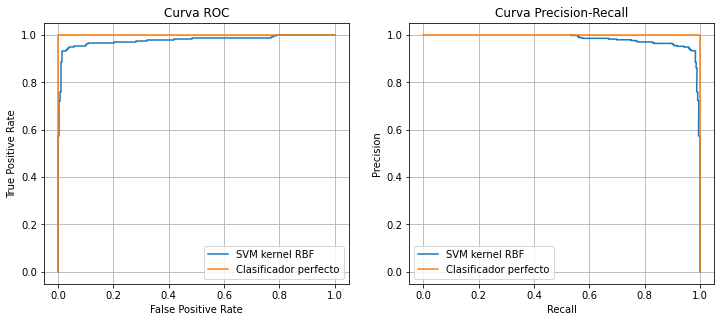

In [28]:
best_classifier_cm = confusion_mtx(rbf_kernel, X_test, y_test)
best_ROC = ROC(rbf_kernel, X_test, y_test)
best_PR = PR(rbf_kernel, X_test, y_test)

def figures(ROC, PR):
  fig, axs = plt.subplots(1, 2, figsize=(12,4.8))
  axs[0].plot(ROC[0], ROC[1], label='SVM kernel RBF')
  axs[0].plot([0,0,1], [0,1,1], label='Clasificador perfecto')
  axs[0].set_xlabel('False Positive Rate')
  axs[0].set_ylabel('True Positive Rate')
  axs[0].set_title('Curva ROC')
  axs[0].legend()
  axs[0].grid()

  axs[1].plot(PR[0], PR[1], label='SVM kernel RBF')
  axs[1].plot([0,1,1], [1,1,0], label='Clasificador perfecto')
  axs[1].set_xlabel('Recall')
  axs[1].set_ylabel('Precision')
  axs[1].set_title('Curva Precision-Recall')
  axs[1].legend()
  axs[1].grid()

  fig.show()

figures(best_ROC, best_PR)

Las métricas que reporta este clasificador se encuentran a continuación.

In [27]:
scores_best = {'Confusion Matrix': [best_classifier_cm],
              'ROC AUC': [best_ROC[2]],
              'Average Precision': [best_PR[2]]}
scores_best_clf = pd.DataFrame(data=scores_best, index=['RBF Kernel'])
scores_best_clf


,Confusion Matrix,ROC AUC,Average Precision
RBF Kernel,"[[320, 8], [22, 306]]",0.976725,0.98303
